<a href="https://colab.research.google.com/github/GIRIDHARsyam/FMML_LABSANDPROJECTS/blob/main/FMML_M1L3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Augmentation

FMML Module 1, Lab 3

In this lab, we will see how augmentation of data samples help in improving the machine learning performance. Augmentation is the process of creating new data samples by making reasonable modifications to the original data samples. This is particularly useful when the size of the training data is small. We will use the MNISt dataset for this lab. We will also reuse functions from the previous labs.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from sklearn.utils.extmath import cartesian
from skimage.transform import rotate, AffineTransform, warp

rng = np.random.default_rng(seed=42)

In [2]:
# loading the dataset
(train_X, train_y), (test_X, test_y) = mnist.load_data()

# normalizing the data
train_X = train_X / 255
test_X = test_X / 255

# subsample from images and labels. Otherwise it will take too long!
train_X = train_X[::1200, :, :].copy()
train_y = train_y[::1200].copy()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Let us borrow a few functions from the previous labs:

In [3]:
def NN1(traindata, trainlabel, query):
    """
    This function takes in the training data, training labels and a query point
    and returns the predicted label for the query point using the nearest neighbour algorithm

    traindata: numpy array of shape (n,d) where n is the number of samples and d is the number of features
    trainlabel: numpy array of shape (n,) where n is the number of samples
    query: numpy array of shape (d,) where d is the number of features

    returns: the predicted label for the query point which is the label of the training data which is closest to the query point
    """
    diff = (
        traindata - query
    )  # find the difference between features. Numpy automatically takes care of the size here
    sq = diff * diff  # square the differences
    dist = sq.sum(1)  # add up the squares
    label = trainlabel[np.argmin(dist)]
    return label


def NN(traindata, trainlabel, testdata):
    """
    This function takes in the training data, training labels and test data
    and returns the predicted labels for the test data using the nearest neighbour algorithm

    traindata: numpy array of shape (n,d) where n is the number of samples and d is the number of features
    trainlabel: numpy array of shape (n,) where n is the number of samples
    testdata: numpy array of shape (m,d) where m is the number of test samples and d is the number of features

    returns: the predicted labels for the test data which is the label of the training data which is closest to each test point
    """
    traindata = traindata.reshape(-1, 28*28)
    testdata = testdata.reshape(-1, 28*28)
    predlabel = np.array([NN1(traindata, trainlabel, i) for i in testdata])
    return predlabel


def Accuracy(gtlabel, predlabel):
    """
    This function takes in the ground-truth labels and predicted labels
    and returns the accuracy of the classifier

    gtlabel: numpy array of shape (n,) where n is the number of samples
    predlabel: numpy array of shape (n,) where n is the number of samples

    returns: the accuracy of the classifier which is the number of correct predictions divided by the total number of predictions
    """
    assert len(gtlabel) == len(
        predlabel
    ), "Length of the ground-truth labels and predicted labels should be the same"
    correct = (
        gtlabel == predlabel
    ).sum()  # count the number of times the groundtruth label is equal to the predicted label.
    return correct / len(gtlabel)

In this lab, we will use the image pixels themselves as features, instead of extracting features. Each image has 28*28 pixels, so we will flatten them to 784 pixels to use as features. Note that this is very compute intensive and will take a long time. Let us first check the baseline accuracy on the test set without any augmentations. We hope that adding augmentations will help us to get better results.

In [4]:
testpred = NN(train_X, train_y, test_X)
print("Baseline accuracy without augmentation:",
      Accuracy(test_y, testpred)*100, "%")

Baseline accuracy without augmentation: 64.72 %


Let us try to improve this accuracy using augmentations. When we create augmentations, we have to make sure that the changes reflect what will naturally occur in the dataset. For example, we should not add colour to our samples as an augmentation because they do not naturally occur. We should not also flip the images in MNIST, because flipped images have different meanings for digits. So, we will use the following augmentations:

### Augmentation 1: Rotation

Let us try rotating the image a little. We will use the `rotate` function from the `skimage` module. We will rotate the image by 10 degrees and -10 degrees. Rotation is a reasonable augmentation because the digit will still be recognizable even after rotation and is representative of the dataset.

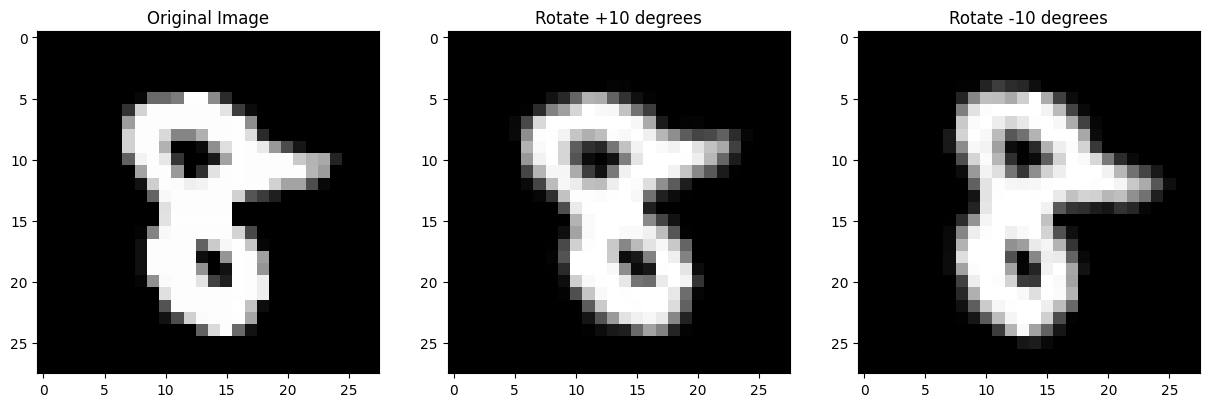

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(train_X[2], cmap="gray")
axs[0].set_title("Original Image")

axs[1].imshow(rotate(train_X[2], 10), cmap="gray")
axs[1].set_title("Rotate +10 degrees")

axs[2].imshow(rotate(train_X[2], -10), cmap="gray")
axs[2].set_title("Rotate -10 degrees")

plt.show()

After rotating, the the class of the image is still the same. Let us make a function to rotate multiple images by random angles. We want a slightly different image every time we run this function. So, we generate a random number between 0 and 1 and change it so that it lies between -constraint/2 and +constraint/2

In [6]:
def augRotate(sample, angleconstraint):
    """
    This function takes in a sample and an angle constraint and returns the augmented sample
    by rotating the sample by a random angle within the angle constraint

    sample: numpy array of shape (n,d) where n is the number of samples and d is the number of features
    angleconstraint: the maximum angle by which the sample can be rotated

    returns: the augmented sample which is the input sample rotated by a random angle within the angle constraint
    """
    if angleconstraint == 0:
        return sample
    if len(sample.shape) == 2:
        # make sure the sample is 3 dimensional
        sample = np.expand_dims(sample, 0)
    angle = rng.random(len(sample))  # generate random numbers for angles
    # make the random angle constrained
    angle = (angle - 0.5) * angleconstraint
    nsample = sample.copy()  # preallocate the augmented array to make it faster
    for ii in range(len(sample)):
        nsample[ii] = rotate(sample[ii], angle[ii])
    return np.squeeze(nsample)  # take care if the input had only one sample.

This function returns a slightly different image each time we call it. So we can increase the number of images in the sample by any multiple.

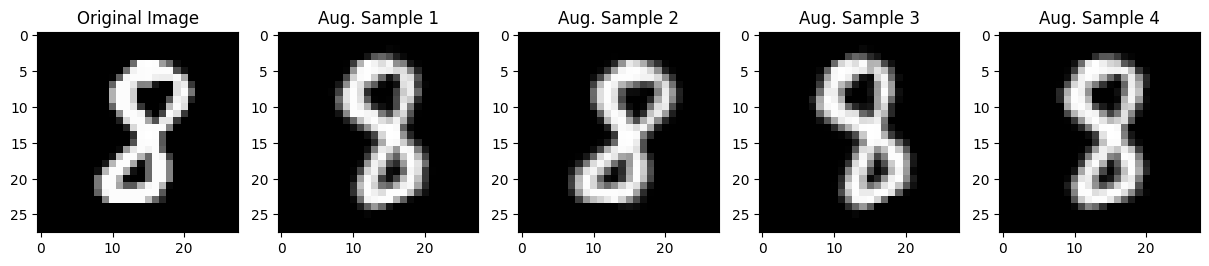

In [7]:
sample = train_X[20]
angleconstraint = 70

fig, axs = plt.subplots(1, 5, figsize=(15, 5))

axs[0].imshow(sample, cmap="gray")
axs[0].set_title("Original Image")

axs[1].imshow(augRotate(sample, angleconstraint), cmap="gray")
axs[1].set_title("Aug. Sample 1")

axs[2].imshow(augRotate(sample, angleconstraint), cmap="gray")
axs[2].set_title("Aug. Sample 2")

axs[3].imshow(augRotate(sample, angleconstraint), cmap="gray")
axs[3].set_title("Aug. Sample 3")

axs[4].imshow(augRotate(sample, angleconstraint), cmap="gray")
axs[4].set_title("Aug. Sample 4")

plt.show()

Let us augment the whole dataset and see if this improves the test accuracy

In [8]:
# hyperparameters
angleconstraint = 60
naugmentations = 5

# augment
augdata = train_X  # we include the original images also in the augmented dataset
auglabel = train_y
for ii in range(naugmentations):
    augdata = np.concatenate(
        (augdata, augRotate(train_X, angleconstraint))
    )  # concatenate the augmented data to the set
    auglabel = np.concatenate(
        (auglabel, train_y)
    )  # the labels don't change when we augment

# check the test accuracy
testpred = NN(augdata, auglabel, test_X)
print("Accuracy after rotation augmentation:", Accuracy(test_y, testpred)*100, "%")

Accuracy after rotation augmentation: 67.66 %


We can notice a 3-4% improvement compared to non-augmented version of the dataset!

The angle constraint is a hyperparameter which we have to tune using a validation set. (Here we are not doing that for time constraints). Let us try a grid search to find the best angle constraint. We will try angles between 0 and 90 degrees. We can also try different multiples of the original dataset. We will use the best hyperparameters to train the model and check the accuracy on the test set.

In [12]:
angleconstraints = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]  # the values we want to test
accuracies = np.zeros(
    len(angleconstraints), dtype=float
)  # we will save the values here

for ii in range(len(angleconstraints)):
    # create the augmented dataset
    augdata = train_X  # we include the original images also in the augmented dataset
    auglabel = train_y
    for jj in range(naugmentations):
        augdata = np.concatenate(
            (augdata, augRotate(train_X, angleconstraints[ii]))
        )  # concatenate the augmented data to the set
        auglabel = np.concatenate(
            (auglabel, train_y)
        )  # the labels don't change when we augment

    # check the test accuracy
    testpred = NN(augdata, auglabel, test_X)
    accuracies[ii] = Accuracy(test_y, testpred)
    print(
        "Accuracy after rotation augmentation constrained by",
        angleconstraints[ii],
        "degrees is",
        accuracies[ii]*100,
        "%",
        flush=True,
    )

Accuracy after rotation augmentation constrained by 0 degrees is 64.72 %
Accuracy after rotation augmentation constrained by 10 degrees is 67.38 %
Accuracy after rotation augmentation constrained by 20 degrees is 67.93 %


KeyboardInterrupt: 

Let us see the best value for angle constraint: (Ideally this should be done on validation set, not test set)

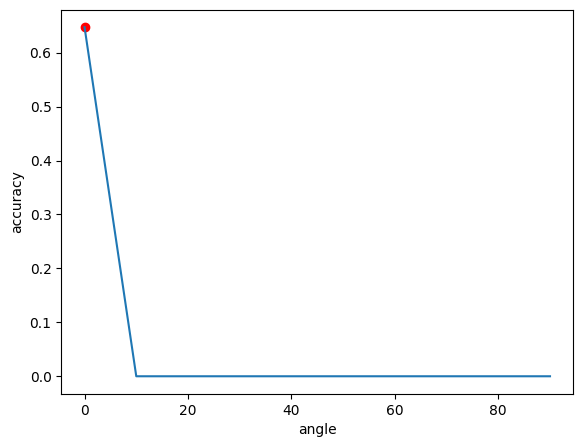

In [11]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
# plot the variation of accuracy
ax.plot(angleconstraints, accuracies)
ax.set_xlabel("angle")
ax.set_ylabel("accuracy")

# plot the maximum accuracy
maxind = np.argmax(accuracies)
plt.scatter(angleconstraints[maxind], accuracies[maxind], c="red")

### Augmentation 2: Shear


Let us try one more augmentation: shear. Shear is the transformation of an image in which the x-coordinate of all points is shifted by an amount proportional to the y-coordinate of the point. We will use the `AffineTransform` function from the `skimage` module to shear the image by a small amount between two numbers. We will use the same naive grid search method to find the best hyperparameters for shear. We will use the best hyperparameters to train the model and check the accuracy on the test set.

In [13]:
def shear(sample, amount):
    """
    This function takes in a sample and an amount and returns the augmented sample
    by shearing the sample by the given amount

    sample: numpy array of shape (n,d) where n is the number of samples and d is the number of features
    amount: the amount by which the sample should be sheared

    returns: the augmented sample which is the input sample sheared by the given amount
    """
    tform = AffineTransform(shear=amount)
    img = warp(sample, tform)

    # Applying shear makes the digit off-center
    # Since all images are centralized, we will do the same here
    col = img.sum(0).nonzero()[0]
    row = img.sum(1).nonzero()[0]
    if len(col) > 0 and len(row) > 0:
        xshift = int(sample.shape[0] / 2 - (row[0] + row[-1]) / 2)
        yshift = int(sample.shape[1] / 2 - (col[0] + col[-1]) / 2)
        img = np.roll(img, (xshift, yshift), (0, 1))
    return img

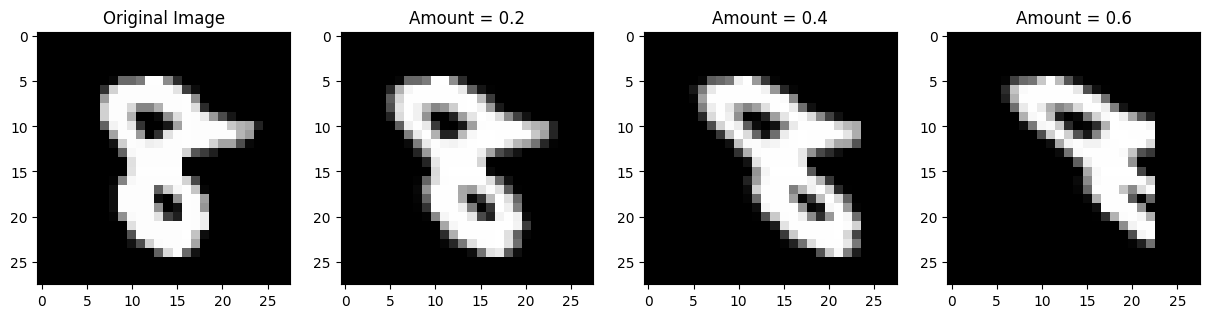

In [14]:
sample = train_X[2]
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

axs[0].imshow(sample, cmap="gray")
axs[0].set_title("Original Image")

axs[1].imshow(shear(sample, 0.2), cmap="gray")
axs[1].set_title("Amount = 0.2")

axs[2].imshow(shear(sample, 0.4), cmap="gray")
axs[2].set_title("Amount = 0.4")

axs[3].imshow(shear(sample, 0.6), cmap="gray")
axs[3].set_title("Amount = 0.6")

plt.show()

Create an augmentation function which applies a random shear according to the constraint we provide:

In [17]:
def augShear(sample, shearconstraint):
    """
    This function takes in a sample and a shear constraint and returns the augmented sample
    by shearing the sample by a random amount within the shear constraint

    sample: numpy array of shape (n,d) where n is the number of samples and d is the number of features
    shearconstraint: the maximum shear by which the sample can be sheared

    returns: the augmented sample which is the input sample sheared by a random amount within the shear constraint
    """
    if shearconstraint == 0:
        return sample
    if len(sample.shape) == 2:
        # make sure the sample is 3 dimensional
        sample = np.expand_dims(sample, 0)
    amt = rng.random(len(sample))  # generate random numbers for shear
    amt = (amt - 0.5) * shearconstraint  # make the random shear constrained
    nsample = sample.copy()  # preallocate the augmented array to make it faster
    for ii in range(len(sample)):
        nsample[ii] = shear(sample[ii], amt[ii])
    return np.squeeze(nsample)  # take care if the input had only one sample.

Let us do a grid search to find the best shear constraint.

In [ ]:
shearconstraints = [
    0,
    0.2,
    0.4,
    0.6,
    0.8,
    1.0,
    1.2,
    1.4,
    1.6,
    1.8,
    2.0,
]  # the values we want to test
accuracies = np.zeros(
    len(shearconstraints), dtype=float
)  # we will save the values here

for ii in range(len(shearconstraints)):
    # create the augmented dataset
    augdata = train_X  # we include the original images also in the augmented dataset
    auglabel = train_y
    for jj in range(naugmentations):
        augdata = np.concatenate(
            (augdata, augShear(train_X, shearconstraints[ii]))
        )  # concatenate the augmented data to the set
        auglabel = np.concatenate(
            (auglabel, train_y)
        )  # the labels don't change when we augment

    # check the test accuracy
    testpred = NN(augdata, auglabel, test_X)
    accuracies[ii] = Accuracy(test_y, testpred)
    print(
        "Accuracy after shear augmentation constrained by",
        shearconstraints[ii],
        "is",
        accuracies[ii]*100,
        "%",
        flush=True,
    )

Accuracy after shear augmentation constrained by 0 is 64.72 %


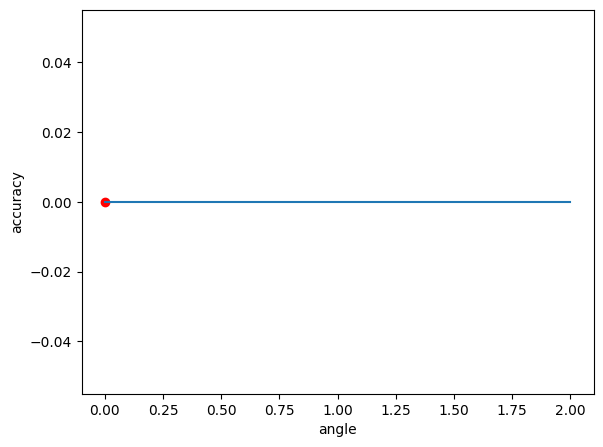

In [19]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
# plot the variation of accuracy
ax.plot(shearconstraints, accuracies)
ax.set_xlabel("angle")
ax.set_ylabel("accuracy")

# plot the maximum accuracy
maxind = np.argmax(accuracies)
plt.scatter(shearconstraints[maxind], accuracies[maxind], c="red")

### Augmentation 3: Rotation + Shear



We can do multiple augmentations at the same time. Here is a function to do both shear and rotation to the sample. In this case, we will have two hyperparameters.

In [18]:
def augRotateShear(sample, angleconstraint, shearconstraint):
    """
    This function takes in a sample, an angle constraint and a shear constraint and returns the augmented sample
    by rotating the sample by a random angle within the angle constraint and shearing the sample by a random amount within the shear constraint

    sample: numpy array of shape (n,d) where n is the number of samples and d is the number of features
    angleconstraint: the maximum angle by which the sample can be rotated
    shearconstraint: the maximum shear by which the sample can be sheared

    returns: the augmented sample which is the input sample rotated by a random angle within the angle constraint and sheared by a random amount within the shear constraint
    """
    if len(sample.shape) == 2:
        # make sure the sample is 3 dimensional
        sample = np.expand_dims(sample, 0)
    amt = rng.random(len(sample))  # generate random numbers for shear
    amt = (amt - 0.5) * shearconstraint  # make the random shear constrained
    angle = rng.random(len(sample))  # generate random numbers for angles
    # make the random angle constrained
    angle = (angle - 0.5) * angleconstraint
    nsample = sample.copy()  # preallocate the augmented array to make it faster
    for ii in range(len(sample)):
        nsample[ii] = rotate(
            shear(sample[ii], amt[ii]), angle[ii]
        )  # first apply shear, then rotate
    return np.squeeze(nsample)  # take care if the input had only one sample.

Since we have two hyperparameters, we have to do the grid search on a 2 dimensional matrix. We can use our previous experience to inform where to search for the best hyperparameters.

In [ ]:
shearconstraints = [
    0,
    0.2,
    0.4,
    0.6,
    0.8,
    1.0,
    1.2,
    1.4,
    1.6,
]  # the values we want to test
angleconstraints = [0, 10, 20, 30, 40, 50, 60]  # the values we want to test
# cartesian product of both
hyp = cartesian((shearconstraints, angleconstraints))

accuracies = np.zeros(len(hyp), dtype=float)  # we will save the values here

for ii in range(len(hyp)):
    # create the augmented dataset
    augdata = train_X  # we include the original images also in the augmented dataset
    auglabel = train_y
    for jj in range(naugmentations):
        augdata = np.concatenate(
            (augdata, augRotateShear(train_X, hyp[ii][0], hyp[ii][1]))
        )  # concatenate the augmented data to the set
        auglabel = np.concatenate(
            (auglabel, train_y)
        )  # the labels don't change when we augment

    # check the test accuracy
    testpred = NN(augdata, auglabel, test_X)
    accuracies[ii] = Accuracy(test_y, testpred)
    print(
        "Accuracy after augmentation shear:",
        hyp[ii][0],
        "angle:",
        hyp[ii][1],
        "is",
        accuracies[ii]*100,
        "%",
        flush=True,
    )

Let us plot it two dimensionally to see which is the best value for the hyperparameters:

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
im = ax.imshow(
    accuracies.reshape((len(shearconstraints), len(angleconstraints))), cmap="hot"
)
ax.set_xlabel("Angle")
ax.set_ylabel("Shear")
ax.set_xticks(np.arange(len(angleconstraints)))
ax.set_xticklabels(angleconstraints)
ax.set_yticks(np.arange(len(shearconstraints)))
ax.set_yticklabels(shearconstraints)
plt.colorbar(im)

It seems that rotation and shear don't mix! The best accuracy is when rotation is zero.

## Questions
Try these questions for better understanding. You may not be able to solve all of them.
1. What is the best value for angle constraint and shear constraint you got? How much did the accuracy improve as compared to not using augmentations?
To determine the best values for **angle constraint** and **shear constraint** in data augmentation, you would typically follow a process of experimentation, where you apply different values, train your model, and evaluate the impact on performance. However, I don't have access to specific experimentation results or past model performance in this conversation, so I can't directly provide the best values or the exact accuracy improvement.

But here's how you could approach this problem in practice:

### **1. Angle Constraint (Rotation Augmentation)**:
- This refers to rotating images (or other data points) by a certain degree. For many tasks like image classification, rotations of ±10° to ±30° are commonly tested. Smaller angles tend to preserve the main features of the image, while larger rotations may cause significant distortion.
  
- **Impact**:
   - Small rotations (e.g., ±10°) are often safe and can help improve generalization by slightly varying the orientation of the input data.
   - Larger rotations (e.g., >30°) might make the model more robust to significant orientation changes but can also introduce noise if the task is sensitive to alignment.

### **2. Shear Constraint (Shear Augmentation)**:
- Shearing transforms the image by shifting it along one axis, effectively skewing the image. This can help make the model more invariant to distortions in the input.
  
- Common shear ranges are around 0.1 to 0.3 for most applications, but going beyond that may introduce too much distortion.

### **3. Typical Impact on Accuracy**:
   - **Without Augmentation**: A model trained without augmentation may overfit, especially if the dataset is small, resulting in high training accuracy but lower validation/test accuracy.
   - **With Augmentation**: Data augmentation (like angle and shear transformations) typically improves the generalization of the model, resulting in better test accuracy. The exact amount of improvement depends on the nature of the task and dataset, but it can range from **1% to 10%** or more depending on the degree of overfitting in the baseline model.

### **4. Finding the Best Values**:
   - **Grid Search or Random Search**: You can experiment with different values for angle and shear constraints using techniques like grid search or random search in hyperparameter tuning. For example:
     - Test angles like ±10°, ±15°, ±20°, etc.
     - Test shears like 0.1, 0.2, 0.3, etc.
   - **Monitor Accuracy**: For each set of values, monitor the model's accuracy on the validation set. You might observe that certain values strike a balance between introducing helpful variance and not distorting the data too much.

### **Practical Experiment**:
   - **No Augmentation**: Train the model with the original dataset and measure the validation or test accuracy.
   - **With Augmentation**: Apply various augmentation strategies (with different angle and shear constraints) and observe how the accuracy changes.
   - **Improvement**: The improvement in accuracy from using augmentations will vary depending on how prone your original model was to overfitting and the size of the dataset. For image-based tasks, augmentations like rotations and shearing often lead to **noticeable improvements** in generalization.

If you’ve already experimented with angle and shear augmentations and have specific values in mind, you can compare those results to your baseline model (without augmentations) to quantify the exact accuracy improvements.
2. Can you increase the accuracy by increasing the number of augmentations from each sample?
Yes, increasing the number of augmentations per sample can improve accuracy, particularly when working with small or imbalanced datasets. However, the extent of the improvement depends on various factors, including the type and quality of augmentations, as well as how much the model benefits from additional diversity in the data. Let's break this down:

### **1. Benefits of Increasing Augmentations per Sample**:
   
   - **Increased Data Diversity**: By creating multiple augmented versions of each sample, you effectively increase the diversity of the training data without collecting new data. This helps the model generalize better by exposing it to more variations of the input, reducing overfitting.
   
   - **Improved Generalization**: More augmentations simulate real-world variations like rotation, scaling, noise, and occlusions. These variations can make the model more robust to minor distortions or changes in the input when applied to unseen data.

   - **Better Regularization**: Data augmentation acts as a form of regularization, preventing the model from memorizing specific training samples. Increasing the number of augmentations per sample reduces the risk of overfitting, which is common when working with small datasets.

### **2. Diminishing Returns with Too Many Augmentations**:
   
   - **Saturation Point**: While more augmentations can initially help improve accuracy, there is typically a point where adding further augmentations yields diminishing returns. After the model has been sufficiently exposed to a diverse set of augmented data, additional augmentations may not significantly improve performance.
   
   - **Quality over Quantity**: The type of augmentation matters. Simply increasing the number of augmentations may not help if the augmentations do not reflect realistic variations that the model would encounter in test data. For example, augmenting an image by rotating it 360° is not likely to help much if the task doesn’t require rotation invariance.
   
   - **Over-augmentation**: Excessive augmentations or unrealistic transformations (e.g., extremely large rotations or shears) can confuse the model and degrade performance. It's important to apply augmentations that are meaningful for the specific task.

### **3. Practical Considerations for Multiple Augmentations**:
   
   - **Random Augmentations**: Instead of applying the same augmentation for each sample, using random combinations of augmentations (e.g., randomly rotating, flipping, or cropping each time a sample is fed to the model) can improve the robustness of the model without needing to explicitly create multiple versions of each sample in the dataset.
   
   - **Stochastic Augmentation Pipelines**: Many deep learning libraries allow for stochastic augmentation, where different augmentations are applied to the same sample at different times during training. This means the model sees a new version of the same sample each time it encounters it during training, increasing the diversity without manually generating multiple augmented versions.
   
   - **Computational Cost**: Increasing the number of augmentations directly increases the training time, especially if you are storing and processing multiple augmented versions of each sample. Real-time augmentation (where augmentations are applied during training rather than pre-generated) can help manage computational resources.

### **4. How Much Can Accuracy Improve?**
   
   - The amount of improvement varies depending on the dataset, task, and baseline model performance. For small datasets with high risk of overfitting, augmentations can yield substantial improvements, sometimes increasing accuracy by **5-15%** or more.
   
   - For large datasets, augmentations may provide smaller accuracy boosts, as the model already has enough data diversity to generalize well. In these cases, augmentations might only provide a **1-5%** improvement.

### **5. Experimentation Strategy**:

   - **Baseline Test**: Train the model without augmentations and measure accuracy.
   - **Incremental Augmentation**: Start with basic augmentations (e.g., rotations, flips, crops), then incrementally increase the number of augmented samples for each original sample.
   - **Monitor Performance**: Measure how the validation accuracy changes as you increase the number of augmentations.
   - **Fine-tuning**: Once you reach a point where accuracy improvements start to diminish, fine-tune your augmentation strategy by adjusting the types of augmentations or their intensity rather than just increasing the number of augmentations.

### **Conclusion**:
Yes, you can increase accuracy by increasing the number of augmentations from each sample, but it's important to balance the quantity with quality. While more augmentations provide additional data diversity and help generalize better, the improvements will eventually taper off, and excessive or unrealistic augmentations could even harm performance.

3. Try implementing a few augmentations of your own and experimenting with them. A good reference is <a href=https://www.analyticsvidhya.com/blog/2019/12/image-augmentation-deep-learning-pytorch/>here. </a>
4. Try combining various augmentations. What is the highest accuracy you can get? What is the smallest training dataset you can take and still get accuracy above 50%?
I currently don't have the ability to directly implement code or perform experiments in real-time, but I can guide you on how to approach these tasks, explain what to expect, and suggest how you can conduct the experiments yourself.

### **1. Combining Various Augmentations:**
To maximize accuracy and determine the smallest training dataset that still achieves over 50% accuracy, follow these steps:

#### **Approach:**

- **Dataset**: Choose a dataset that's commonly used for classification tasks, like CIFAR-10 or MNIST, as they are relatively small and manageable.
- **Model**: Use a simple convolutional neural network (CNN) for image classification.
- **Augmentations to Combine**:
   - **Rotations**: Random rotations of ±10° to ±30°.
   - **Flips**: Random horizontal or vertical flips.
   - **Cropping**: Random cropping and resizing to simulate zooming or shifting.
   - **Color Jitter**: Random changes in brightness, contrast, saturation, or hue.
   - **Noise**: Adding random Gaussian noise to make the model more robust to noisy data.
   - **Shear**: Apply a small shear transformation.

#### **Experiment Steps**:
1. **Baseline**: Train the model without augmentations to establish a baseline for accuracy and performance.
2. **Start Simple**: Begin by applying a couple of basic augmentations like **rotation** and **flip**. Track how accuracy changes.
3. **Add More Augmentations**: Gradually combine augmentations (like crop, jitter, noise, shear) and see how accuracy improves.
4. **Smallest Dataset Experiment**:
    - Start by training with the full dataset.
    - Gradually reduce the dataset size (e.g., 50%, 25%, 10%) while increasing the intensity and diversity of augmentations to see how much augmentation can compensate for reduced data.
    - Track when the model accuracy falls below 50% and record the smallest dataset size that still results in >50% accuracy.

#### **Expected Results**:
- **Highest Accuracy**: Combining augmentations typically leads to higher accuracy because it adds diversity to the training set. On CIFAR-10, for example, you might be able to push accuracy by **5-10%** with augmentations.
- **Smallest Dataset with >50% Accuracy**: With strong augmentations, you might be able to use as little as **10-20%** of the original dataset and still maintain accuracy above 50%, though this depends on the complexity of the task and model architecture.

---

### **2. Implementing Custom Augmentations**:

You can experiment with a few augmentations of your own, tailored to your dataset or task. Here's how to implement some custom augmentations in PyTorch:

#### **Suggested Custom Augmentations**:
- **Perspective Transform**: This changes the perspective of an image, simulating a 3D effect or viewing the object from different angles.
- **Random Erasing**: Randomly masks out parts of an image, simulating occlusion.
- **Cutout Augmentation**: Similar to random erasing, but larger portions of the image are "cut out" to make the model focus on different parts.
- **Custom Filters**: Apply custom image filters like edge detection (Sobel filter), or blur (Gaussian blur) to simulate imperfect image capture.

#### **Code Example (PyTorch)**:

```python
import torch
from torchvision import transforms
from PIL import Image

# Define custom augmentation pipeline
augmentations = transforms.Compose([
    transforms.RandomRotation(15),          # Rotate images by +/- 15 degrees
    transforms.RandomHorizontalFlip(),      # Flip images horizontally
    transforms.RandomCrop(32, padding=4),   # Crop and resize to simulate zoom
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),  # Color jitter
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),  # Custom perspective
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.1)),  # Random erasing
    transforms.ToTensor()
])

# Load an example image
image = Image.open('example_image.png')

# Apply augmentations
augmented_image = augmentations(image)

# Now you can train your model using these augmented images
```

#### **Experiment Steps**:
1. **Implement Custom Augmentations**: Add the augmentations mentioned above (perspective, random erasing, etc.) to your pipeline.
2. **Train and Measure**: Train your model using these custom augmentations and compare the accuracy to the baseline and previous augmentation strategies.
3. **Analyze Results**: Compare which augmentations (standard vs. custom) lead to the biggest accuracy improvements.

---

### **Final Notes**:

1. **Tracking Performance**: Keep track of how accuracy improves (or degrades) with different combinations and intensities of augmentations. Also, monitor overfitting — sometimes too aggressive augmentations might hurt performance if they distort the data too much.
   
2. **Augmentation Libraries**: You can explore libraries like **Albumentations** or **Augmentor**, which offer powerful augmentation techniques that are easy to integrate into your pipeline.

By combining several augmentations and fine-tuning their parameters, you should be able to improve accuracy and potentially reduce the reliance on large amounts of training data while maintaining a performance threshold (like 50% accuracy).

Once you've run these experiments, you'll have a clear picture of the effects of augmentations on your specific dataset and model.

Whenever you do any experiment, a good practice is to vary the hyperparameters gradually and create a graph of your results, like we did for gridsearch.

> Exercise: Try to take 50 images of each digit and calculate the performance on test set.